# Comparing the initial Simulation to the extracted Connectivity

In [5]:
from n_corr_functions import *
from scipy.stats import pearsonr
import seaborn as sns
from tqdm.notebook import tqdm_notebook as tqdm
#plt.style.use('dark_background')
#plt.rcParams['axes.facecolor'] = 'none'
import netrd


In [6]:
seed = 25
num_neurons = 10
p = 0.1
maxweight = 100
hilo = [0,1]
simmetry = False

conn, dconn = generate_connectivity_and_weights(num_neurons,p,maxweight, hilo, seed, simmetry)
data_model = run_model(conn, dconn, seed)

In [7]:
th1 = 0
th2 = 0
l1_threshold = 0.1
l2_treshold = 0.1
dcov, _, _ = dCov(data_model, 0.1, 0.1, 0.1, False, False, True)   
for i in range(len(dcov)):
    dcov[i,i] = 0

dcov[dcov < 0.3] = 0
#data[np.abs(dcov) < threshold] = 0
l_conn, _, n_corr = lag_corr_matrix(data_model, 1, 0, False, l1_threshold, l2_treshold)
c_m = merge_matrix(l_conn, dcov, th1, th2)



ddc_thresh = 0.1
ddc_threshed = np.copy(dcov)
ddc_threshed[ddc_threshed < ddc_thresh] = 0
c_m_thresh = 0.1
c_m_threshed = np.copy(c_m)
c_m[c_m_threshed < c_m_thresh] = 0
data_model2 = run_model(c_m, c_m, seed)
data_model3 = run_model(dcov, dcov, seed)
#data_model3 = run_model(np.zeros_like(c_m), np.zeros_like(c_m), seed)

correlations = [pearsonr(conn.flatten(), c_m.flatten())[0], pearsonr(conn.flatten(), ddc_threshed.flatten())[0]]

l = 0
pc = []
pc2 = []
for i in range(len(data_model.T)):
    pr = pearsonr(data_model.T[i], data_model2.T[i])[0]
    l += pr
    pc.append(pr)

x = 0
for i in range(len(data_model.T)):
    pr = pearsonr(data_model.T[i], data_model3.T[i])[0]
    x += pr
    pc2.append(pr)
print("Mean Pearson of original and simulated data: ", l/len(data_model.T))
print("Mean Pearson of original and simulated data without lag: ", x/len(data_model.T))

Mean Pearson of original and simulated data:  0.983268337374338
Mean Pearson of original and simulated data without lag:  0.8394262899380868


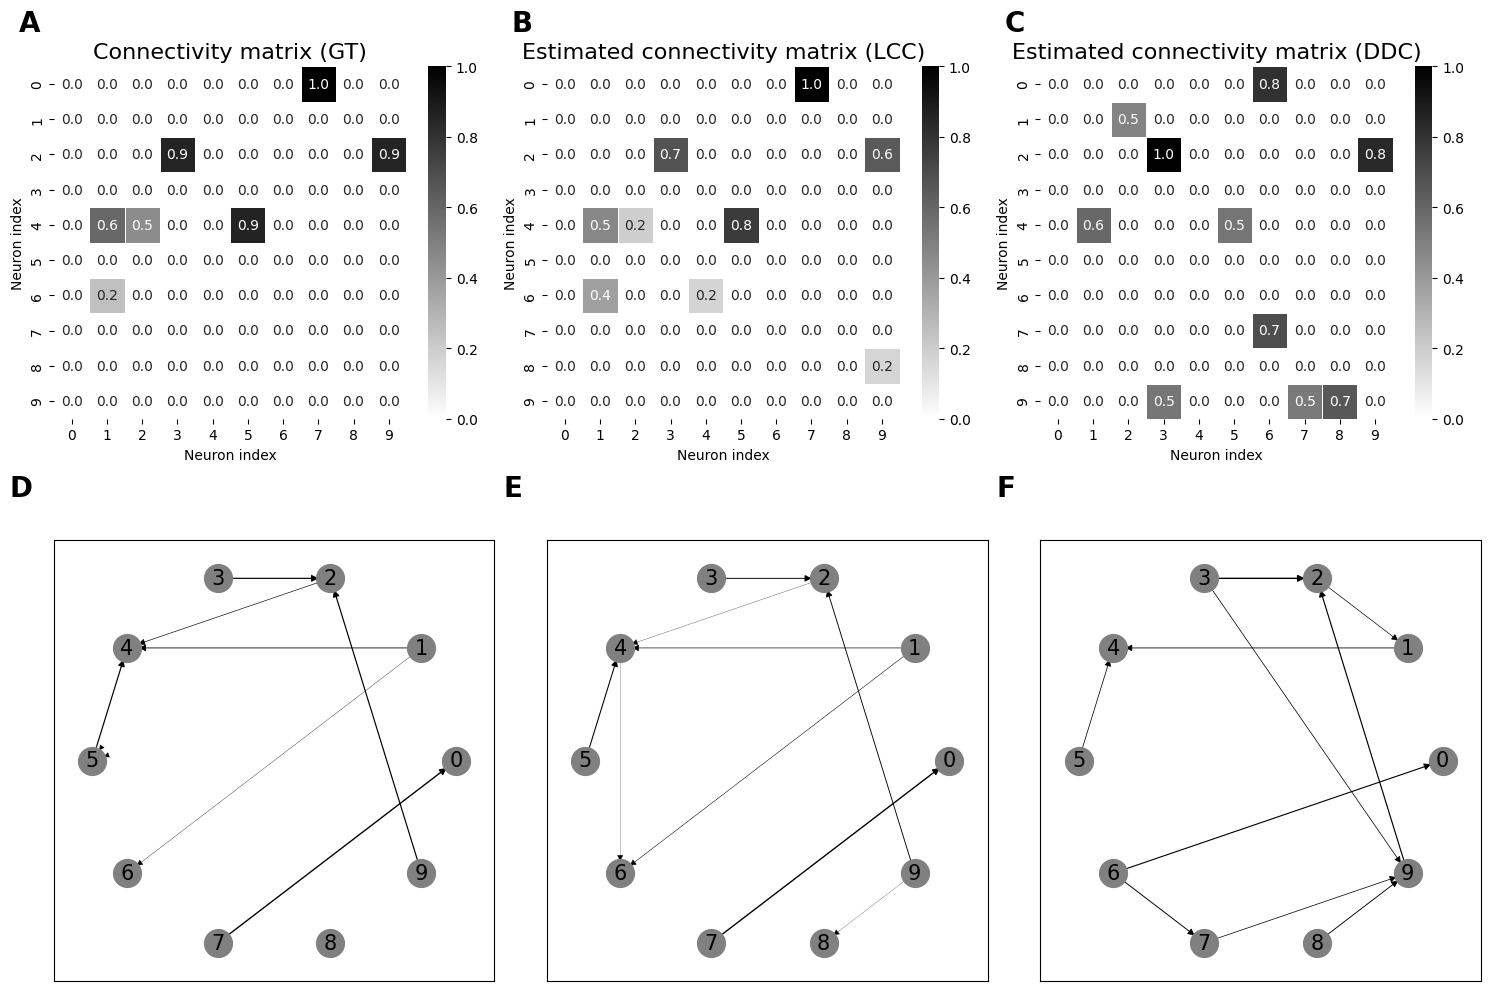

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

threshold = 0.0
show_labels = False
data_matrices = [normalize_matrix(conn), normalize_matrix(c_m), normalize_matrix(dcov)]

fig, axs = plt.subplots(2, 3, figsize=(15,10))

for idx, data in enumerate(data_matrices):
    G = nx.DiGraph()
    for i in range(data.shape[0]):
        G.add_node(i)

    n_connections = data.shape[0]
    for c_neuron in range(n_connections):
        for j in range(n_connections):
            if(c_neuron != j):
                if data[c_neuron, j] > threshold:
                    G.add_edge(j, c_neuron, color = 'black', weight = np.around(data[c_neuron, j], 4))
                elif data[c_neuron, j] < -threshold:
                    G.add_edge(c_neuron, j, color = 'blue', weight = np.around(np.abs(data[c_neuron, j]), 3))

    #pos = nx.kamada_kawai_layout(G)
    pos = nx.circular_layout(G)
    edges = G.edges
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight'] for u,v in edges]
    # Draw nodes and edges separately
    nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, ax=axs[1, idx], font_size=15)
    nx.draw_networkx_nodes(G, pos, node_color = "grey", node_size = 400, ax = axs[1, idx])
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=weights, ax=axs[1, idx]) # Add width parameter
    

    if(show_labels):
        labels = nx.get_edge_attributes(G,'weight')
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, label_pos=0.5,font_size=5, ax=axs[1, idx])

    # Add plot name
    plot_names = ['Connectivity matrix (GT)', 'Estimated connectivity matrix (LCC)', 'Estimated connectivity matrix (DDC)']
    axs[0, idx].set_title(plot_names[idx], fontsize=16)
    

    sns.heatmap(data, cmap='gray_r', ax=axs[0, idx], annot=True, fmt=".1f", square=True,
            cbar_kws={"shrink": 0.8},
            linewidths=0.5)
    axs[0, idx].set_xlabel('Neuron index')
    axs[0, idx].set_ylabel('Neuron index')




axs[0, 0].text(-0.1, 1.1, 'A', transform=axs[0, 0].transAxes, size=20, weight='bold')
axs[0, 1].text(-0.1, 1.1, 'B', transform=axs[0, 1].transAxes, size=20, weight='bold')
axs[0, 2].text(-0.1, 1.1, 'C', transform=axs[0, 2].transAxes, size=20, weight='bold')
axs[1, 0].text(-0.1, 1.1, 'D', transform=axs[1, 0].transAxes, size=20, weight='bold')
axs[1, 1].text(-0.1, 1.1, 'E', transform=axs[1, 1].transAxes, size=20, weight='bold')
axs[1, 2].text(-0.1, 1.1, 'F', transform=axs[1, 2].transAxes, size=20, weight='bold')


plt.tight_layout()
plt.savefig('connectivity_matrix_and_graph.png', dpi = 300)
plt.show()




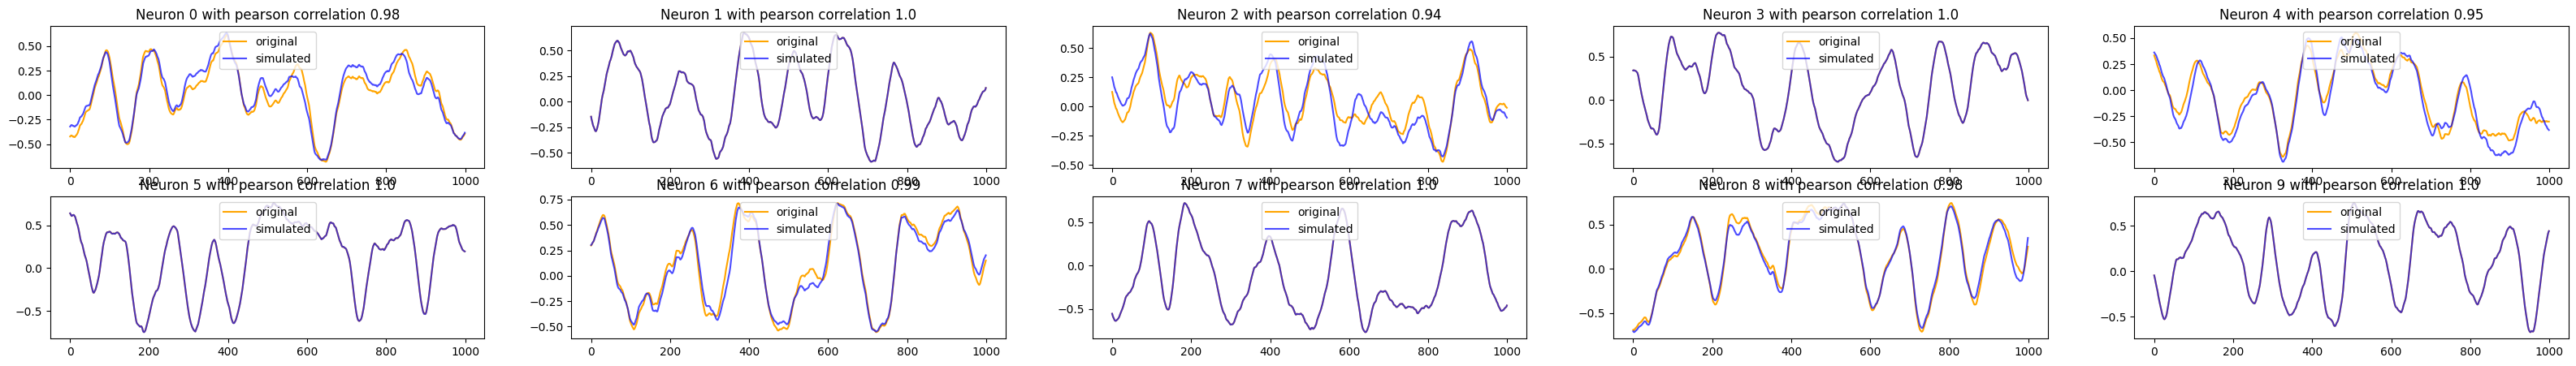

In [9]:
fig, axs = plt.subplots(2, 5, figsize=(40, 5), facecolor='none')
for i, ax in enumerate(axs.flat):
    ax.plot(data_model.T[i][:1000], label='original', color='orange')
    ax.plot(data_model2.T[i][:1000], label='simulated', color='blue' ,alpha=0.7)
    ax.legend(loc='upper center')
    ax.set_title(f'Neuron {i} with pearson correlation {np.round(pearsonr(data_model.T[i], data_model2.T[i])[0], 2)}')

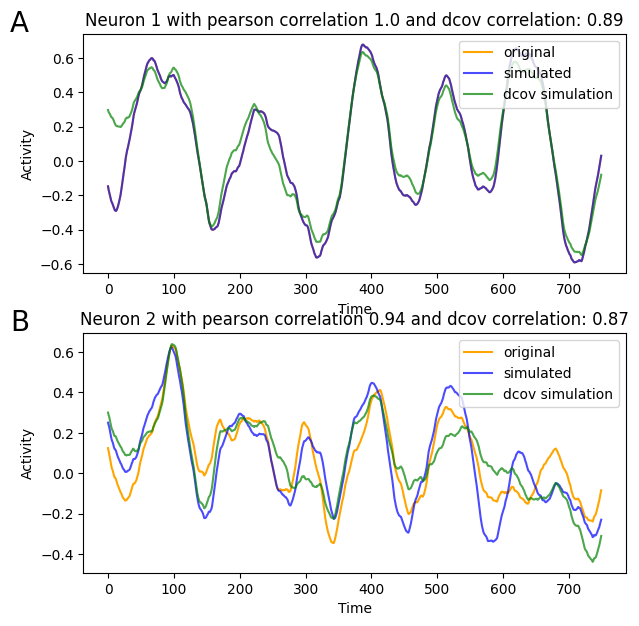

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7), gridspec_kw={'hspace': 0.25})


d_r = 750

for i, ax in enumerate(axs.flat):
    i = i+1
    ax.plot(data_model.T[i][:d_r], label='original', color='orange')
    ax.plot(data_model2.T[i][:d_r], label='simulated', color='blue', alpha=0.7)
    ax.plot(data_model3.T[i][:d_r], label='dcov simulation', color='green', alpha=0.7)
    # annotate the x axis with x
    ax.set_xlabel('Time')
    # annotate the y axis with y
    ax.set_ylabel('Activity')
    ax.legend(loc='upper right')
        # Adding labels A and B in the top left corner, left of the axis
    if i == 1:  # Upper plot
        ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='right')
    else:  # Lower plot
        ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='right')


    ax.set_title(f'Neuron {i} with pearson correlation {np.round(pearsonr(data_model.T[i], data_model2.T[i])[0], 2)} and dcov correlation: {np.round(pearsonr(data_model.T[i], data_model3.T[i])[0], 2)}')

plt.savefig('comparison_hopf.png', dpi=300)

plt.show()